In [122]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.ops import nearest_points
from shapely.geometry import Point, LinearRing
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from os import path
import urllib.request
import pickle
from math import atan2, degrees


In [2]:
import urllib, os, json
down_loc = os.getcwd()
down_loc

'C:\\Users\\User\\Documents\\GitHub\\sidewalks_deep-learning'

Outline: 
* data sourcing
    * set up google api to download images
    * generate random lat, long
    * test location for being in urban area covered by map
    * use street view to find nearest image
    * get image metadata inc lat lon & direction
    * see if there is sidewalk centerline w/in 10ft?, create label in dataframe
* modeling
    * create tf model to classify images, train/test/validate
* use pretrained model to do object detection of sidewalks
* cluster sidewalks by type
    

In [3]:
pwd

'C:\\Users\\User\\Documents\\GitHub\\sidewalks_deep-learning'

In [4]:
#download data sources if not there
data_urls = {}
data_urls['sidewalk_extent'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_extent_centerline_sidewalks&outputFormat=application%2Fjson'
data_urls['sidewalk_centerlines'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_centerline_sidewalks&outputFormat=application%2Fjson'
data_urls['road_borders'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_eop_line&outputFormat=application%2Fjson'
data_urls['road_polygons'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_eop_poly&outputFormat=application%2Fjson'
for key, value in data_urls.items():
    if not path.exists(key + ".geojson"):
        urllib.request.urlretrieve(value, key + '.geojson')

In [5]:
sidewalk_gdf = gpd.read_file('sidewalk_centerlines.geojson')
sidewalk_extent_gdf = gpd.read_file('sidewalk_extent.geojson')
road_polygons_gdf = gpd.read_file('road_polygons.geojson')

In [6]:
sidewalk_gdf.head()

,id,gid,createdate,createuser,type,comments,update_sta,unique_id,geometry
0,planimetrics_2016_centerline_sidewalks.534414,534414,2016-04-08,Kucera,Sidewalk,None,N,534414,"MULTILINESTRING ((3096575.759 1779104.505, 309..."
1,planimetrics_2016_centerline_sidewalks.534415,534415,2016-04-08,Kucera,Sidewalk,None,N,534415,"MULTILINESTRING ((3095429.059 1779035.067, 309..."
2,planimetrics_2016_centerline_sidewalks.534416,534416,2016-04-08,Kucera,Other crossing,None,N,534416,"MULTILINESTRING ((3096759.611 1779106.863, 309..."
3,planimetrics_2016_centerline_sidewalks.534417,534417,2016-04-08,Kucera,Sidewalk,None,N,534417,"MULTILINESTRING ((3096821.734 1779106.976, 309..."
4,planimetrics_2016_centerline_sidewalks.534418,534418,2016-04-08,Kucera,Sidewalk,None,N,534418,"MULTILINESTRING ((3096759.611 1779106.863, 309..."


In [7]:
sidewalk_extent_gdf.head()

,id,gid,sqmi,geometry
0,planimetrics_2016_extent_centerline_sidewalks.1,1,1378.109985,"MULTIPOLYGON (((3138537.128 1894378.599, 31385..."


In [8]:
road_polygons_gdf.head()

,id,gid,createdate,createuser,surface,type,comments,update_sta,unique_id,geometry
0,planimetrics_2016_eop_poly.1,1,2015-07-08,Kucera,Paved,Corridor,None,M,1,"MULTIPOLYGON (((3178008.528 1680396.903, 31780..."
1,planimetrics_2016_eop_poly.2,2,2015-07-08,Kucera,Paved,Corridor,None,M,2,"MULTIPOLYGON (((3177083.131 1680684.331, 31770..."
2,planimetrics_2016_eop_poly.3,3,2015-07-08,Kucera,Paved,Corridor,None,M,3,"MULTIPOLYGON (((3175748.021 1679192.504, 31757..."
3,planimetrics_2016_eop_poly.4,4,2015-07-08,Kucera,Paved,Corridor,None,M,4,"MULTIPOLYGON (((3171378.719 1680722.643, 31714..."
4,planimetrics_2016_eop_poly.5,5,2015-07-08,Kucera,Paved,Corridor,None,M,5,"MULTIPOLYGON (((3171676.961 1684022.116, 31716..."


### check/fix geometry projection

In [9]:
total_bounds = sidewalk_gdf.geometry.total_bounds
total_bounds

array([2935159.7025    , 1508775.0615    , 3411162.9985    ,
       1980230.98999999])

In [10]:
sidewalk_extent_gdf.geometry.total_bounds

array([2932503.25159384, 1503238.87488092, 3414549.89051701,
       1991021.48166284])

desired bounds: 39-41; - 104-106

In [11]:
sidewalk_extent_gdf.geometry.crs

{'init': 'epsg:6428'}

In [12]:
road_polygons_gdf = road_polygons_gdf.to_crs(epsg=4326)

In [13]:
sidewalk_gdf = sidewalk_gdf.to_crs(epsg=4326)
sidewalk_gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

In [14]:
sidewalk_extent_gdf = sidewalk_extent_gdf.to_crs(epsg=4326)
print(f'sidewalk extent crs:{sidewalk_extent_gdf.geometry.crs} \nexample coordinates {sidewalk_extent_gdf.geometry.centroid}')

sidewalk extent crs:{'init': 'epsg:4326', 'no_defs': True} 
example coordinates 0    POINT (-104.97145 39.80632)
dtype: geometry


### Latitude & Longitude:
Coordinates for sidewalk data set are in *Longitude*, **Latitude** format. 
Google Streetview API takes **Latitude**, *Longitude* format.

# Find Points and Download Images

In [19]:
# geometry merger is very slow operation, so the merged geometry is saved the first time 
# and then loaded for subsequent notebook runs
roads_file = "roads_unified_geo.pickle"
if not path.exists(roads_file):
    # todo: uncomment: roads_unified_geo = shapely.ops.unary_union(road_polygons_gdf.geometry)
    # open the file for writing
    with open(roads_file,'wb') as roads_file_object:
        pickle.dump(roads_unified_geo, roads_file_object)
else:
    with open(roads_file, 'rb') as roads_file_object:
        roads_unified_geo = pickle.load(roads_file_object)

EOFError: Ran out of input

In [ ]:
# Verify the merger looks right
roads_unified_geo_gdf = gpd.GeoDataFrame()
roads_unified_geo_gdf['geometry'] = None
roads_unified_geo_gdf.loc[0, 'geometry'] = roads_unified_geo

fig_rd_outline, ax_rd_outline = plt.subplots(figsize = (12,12))
roads_unified_geo_gdf.geometry.plot(ax=ax_rd_outline)
ax_rd_outline.set_xlim(-105, -104.97)
ax_rd_outline.set_ylim(39.75, 39.78)
ax_rd_outline.set_title('Filled Road MultiPolygon', fontsize=20);

In [20]:
shapely.ops.nearest_points(roads_unified_geo, point2)[0].coords.xy

NameError: name 'roads_unified_geo' is not defined

In [ ]:
shapely.ops.nearest_points(roads_unified_geo, point2)[1].coords.xy

In [246]:
class coordinate_generator(object):
    '''
    Creates random points and tests for appropriateness for image downloading. Generates heading for appropriate points.
    '''
    def __init__(self, sidewalk_polygon=sidewalk_extent_gdf.geometry, road_polygons=road_polygons_gdf, 
                 lines=sidewalk_gdf.geometry):
        self.sidewalk_polygon = sidewalk_polygon
        self.road_polygons = road_polygons
        #self.road_polygon['rep_points'] = self.road_polygon.geometry.apply(lambda obj: obj.representative_point()) # for closest ob finder
        self.lines = lines
        self.confirmed_locations = []
    #generate random locations within boundaries
    def generate_numbers(self, number):
        (min_lon, min_lat, max_lon, max_lat) = self.sidewalk_polygon.total_bounds
        counter = 0
        while counter < number:
            pnt = Point(random.uniform(min_lon, max_lon), random.uniform(min_lat, max_lat))
            if not self.sidewalk_polygon.contains(pnt).any(0):
                continue
            closest_obj = self.closest_obj_finder(point=pnt, objects=road_polygons_gdf.copy())
            if not closest_obj.contains(pnt): # check for both because first check is much faster
                continue
            # get direction towards nearest street edge, eg direction towards sidewalk
            decomposed_mpoly = gpd.GeoDataFrame()
            decomposed_mpoly['geometry'] = None
            #decomposed_mpoly['outline'] = None
            for obj in closest_obj:
                decomposed_mpoly.loc[decomposed_mpoly.shape[0]+1,'geometry'] = obj.exterior
                for o in obj.interiors:
                    decomposed_mpoly.loc[decomposed_mpoly.shape[0]+1,'geometry'] = o

            #decomposed_mpoly['geometry'] = decomposed_mpoly['outline'].apply(lambda x: LinearRing(x))
            nearest_pnt = nearest_points(self.closest_obj_finder(pnt, decomposed_mpoly), pnt)[0]

            xdiff = nearest_pnt.x - pnt.x
            ydiff = nearest_pnt.y - pnt.y
            direction = degrees(atan2(ydiff, xdiff)) # atan2 input (y,x)
            result = [direction, pnt]
            self.confirmed_locations.append(_to_coords(result))
            counter += 1
    def closest_obj_finder(self, point, objects):
        '''finds closest point on a geoframe's geometry'''
        objects['dist_to_pnt'] = objects.geometry.apply(lambda obj: obj.distance(point))
        objects = objects.sort_values(by=['dist_to_pnt'])
        closest_object = objects[objects.index.values == objects.iloc[[0],:]
                          .apply(lambda obj: nearest_points(obj.geometry, point)[0], axis=1)
                          .index.values].geometry.values[0]
        return closest_object

    def _to_coords(self, location):
        '''
        change shapely points to list with reverse order of points; [heading, [lon,lat]]->[heading, [lat,lon]]
        '''
        return [location[0], [item[0] for item in location[1].xy][::-1]]

find if rand point is in a polygon
    find nearest polygon
    test for within
find angle
    create linear ring
    find nearest point
    determine angle of line with nearest pnt and original

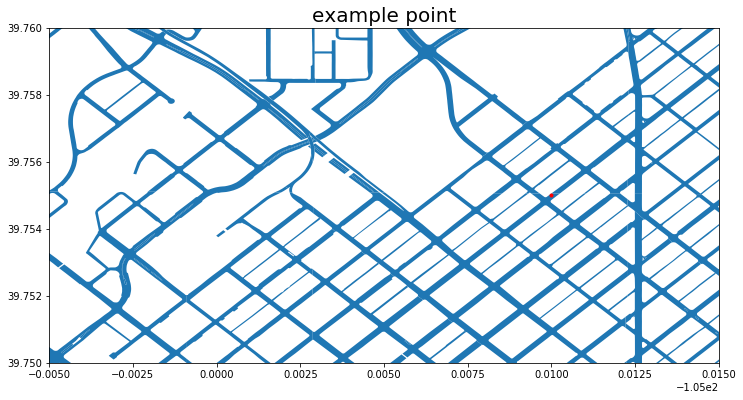

In [59]:
# Verify the merger looks right
fig_rd_outline, ax_rd_outline = plt.subplots(figsize = (12,12))
road_dist_gdf.geometry.plot(ax=ax_rd_outline)
plt.plot(point.x, point.y, marker='o', markersize=3, color="red")
ax_rd_outline.set_xlim(-105.005, -104.985)
ax_rd_outline.set_ylim(39.750, 39.760)
ax_rd_outline.set_title('example point', fontsize=20);

## Create custom downloading function

In [418]:
def MetaParse(metadata_url: str) -> tuple:
    '''
    Uses metadata url to retrieve metadata for the pano image.
    Args:
        metadata_url: A string containing a valid url
    Returns:
         A tuple with the json data date and the pano_id
    '''
    response = urllib.request.urlopen(metadata_url)
    json_raw = response.read()
    json_data = json.loads(json_raw)
    #return data from json response
    if json_data['status'] == "OK":
        if 'date' in json_data:
            return (json_data['date'],json_data['pano_id']) #sometimes it does not have a date!
        else:
            return (None,json_data['pano_id'])
    else:
        return (None,None)

In [419]:
image_list = [] #Global list of images     
def GetStreetvw(Lat, Lon, Head, img_dim=(800,800), fov=90, radius=1000, SaveLoc='.\images') -> list:
    '''
    Downloads images from google api based on parameters specified
    Args:
        Lat: Latitude
        Lon: Longitude
        Head: Heading (direction) that camera is pointing towards
        img_dim: tuple of int specifying image size
        fov: degrees of field of view for image
        radius: meters for radius of search area for nearest pano
        SaveLoc: where images get saved
    Returns:
         A list of images downloaded.
         Main effect of function is to download images into directory.
    '''
    #Dev key is unique to each user. To run this notebook, create your own dev key and store in directory in a text file of this name.
    keyloc="google_dev_key.key"
    with open(keyloc, 'r') as keyfile:
        google_key=keyfile.read()
        
    #create urls from components
    base = r"https://maps.googleapis.com/maps/api/streetview"
    size = r"?size=" + str(img_dim[0]) + 'x' + str(img_dim[1]) + '&fov=' + str(fov)
    loc = '&location=' + str(Lat) + "," + str(Lon) +  "&radius=" + str(radius) + "&key=" #"&heading=" + str(Head) +
    
    metadata_url = base + r"/metadata" + size + loc + google_key
    file_url = base + size + loc + google_key
    file_name = "lat" + str(Lat) + "lon" + str(Lon) + "head" + str(Head) + ".jpg"
   
    met_lis = list(MetaParse(metadata_url)) 
    if not path.exists(SaveLoc):
        os.mkdir(SaveLoc) 
    if (met_lis[1],Head) not in image_list: #and met_lis[0] is not None:   #PrevImage is global list
        urllib.request.urlretrieve(file_url, os.path.join(SaveLoc, file_name))
        met_lis.append(file_name)
        PrevImage.append((met_lis[1],Head)) 
    else:
        met_lis.append(None)
    #delete key to avoid storing in public github-hosted notebook
    del(google_key)
    return met_lis  

In [398]:
GetStreetvw(Lat=40.7036043470179800, Lon=-74.0143908501053400, Head=90)

['2011-06',
 '5MCKvmvlETzgHvMQl8EEIA',
 'lat40.70360434701798lon-74.01439085010534head90.jpg']

In [416]:
for loc in to_coords(generate_random_loc(5)):
    GetStreetvw(*loc, Head=0)

In [ ]:
GetStreetvw()

### Plotting Data

In [149]:
CO_cnty_lines_url = r'https://opendata.arcgis.com/datasets/66c2642209684b90af84afcc559a5a02_5.kml?outSR=%7B%22latestWkid%22%3A4269%2C%22wkid%22%3A4269%7D'
# data sourced from https://data-cdphe.opendata.arcgis.com/datasets/66c2642209684b90af84afcc559a5a02_5
!curl -o CO_county_lines.kml $CO_cnty_lines_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  527k    0  527k    0     0   419k      0 --:--:--  0:00:01 --:--:--  419k
100 2127k    0 2127k    0     0   945k      0 --:--:--  0:00:02 --:--:--  944k
100 3678k    0 3678k    0     0  1131k      0 --:--:--  0:00:03 --:--:-- 1131k
100 5550k    0 5550k    0     0  1302k      0 --:--:--  0:00:04 --:--:-- 1302k
100 5572k    0 5572k    0     0  1307k      0 --:--:--  0:00:04 --:--:-- 1410k


In [152]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
CO_county_lines_gdf = gpd.read_file('CO_county_lines.kml', driver='KML')

In [153]:
CO_county_lines_gdf.head()

,Name,Description,geometry
0,,,"POLYGON ((-105.05673 40.34929, -105.05664 40.3..."
1,,,"POLYGON ((-104.14319 37.75834, -104.14408 37.7..."
2,,,"POLYGON ((-105.36890 38.25941, -105.36889 38.2..."
3,,,"POLYGON ((-106.79970 38.97966, -106.80041 38.9..."
4,,,"POLYGON ((-106.14888 37.40111, -106.15066 37.4..."


In [180]:
CO_county_lines_gdf.geometry.crs

{'init': 'epsg:4326'}

 metadata from https://gis.drcog.org/rdc/xml/planimetrics_2016_centerline_sidewalks.xml

In [182]:
CO_county_lines_gdf.geometry.crs = {'init': 'epsg:4326'}

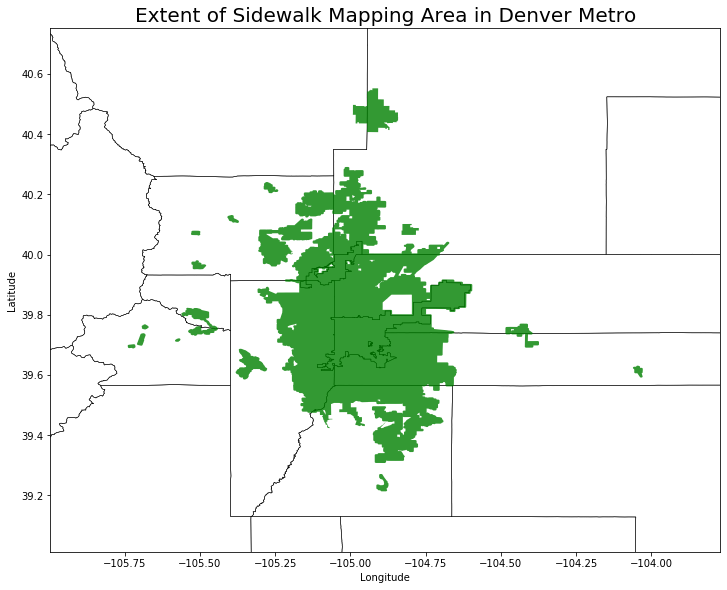

In [244]:
#establish boundaries
minx, miny, maxx, maxy = sidewalk_extent_gdf.geometry.total_bounds
xdiff = maxx - minx
ydiff = maxy - miny
maxx += .15*xdiff
minx -= .15*xdiff
maxy += .15*ydiff
miny -= .15*ydiff

#plot geometries
fig, ax = plt.subplots(figsize = (12,12))
CO_county_lines_gdf.geometry.plot(facecolor='none', linewidth=.5, edgecolor='k', ax=ax)
sidewalk_extent_gdf.geometry.plot(facecolor='g', linewidth=0, edgecolor='g', alpha=0.8, ax=ax)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Extent of Sidewalk Mapping Area in Denver Metro', fontsize=20)
plt.plot();

#### denver roads shapefile
roads_url = https://koordinates.com/layer/101991-denver-colorado-street-centerline/  
requires koordinates login to download

In [51]:
!unzip 'kx-denver-colorado-street-centerline-SHP.zip'

Archive:  kx-denver-colorado-street-centerline-SHP.zip
  inflating: denver-colorado-street-centerline.shx  
  inflating: denver-colorado-street-centerline.shp  
  inflating: denver-colorado-street-centerline.prj  
  inflating: denver-colorado-street-centerline.cpg  
  inflating: denver-colorado-street-centerline.dbf  
  inflating: denver-colorado-street-centerline.txt  


In [55]:
denver_streets_gdf = gpd.read_file('denver-colorado-street-centerline.shp')

In [56]:
denver_streets_gdf.head()

,FNODE,TNODE,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,PREFIX,...,T_ZLEV,ADMINCLASS,LRSROUTE,LRSCOMMENT,LRSBGN,LRSEND,HUNDBLKNAM,LRSMAJ,SHAPE_Leng,geometry
0,7833,7659,225.0,18944,20170608,561.0,599.0,560.0,598.0,N,...,0,2,ROSLYN ST7,LL,189.096668,371.004124,None,None,0.000477,"LINESTRING (-104.90097 39.72508, -104.90096 39..."
1,17472,17471,1607.0,27495,20170612,2851.0,2949.0,2850.0,2948.0,N,...,0,2,IOLA ST,LL,1003.936285,1492.316125,2850 BLK OF N IOLA ST,None,0.001341,"LINESTRING (-104.86455 39.75750, -104.86453 39..."
2,6163,6077,585.0,16501,20171024,400.0,498.0,401.0,499.0,None,...,0,2,13TH ST2,LR,142.786524,487.322780,400 BLK OF 13TH ST,None,0.001102,"LINESTRING (-104.99318 39.74039, -104.99360 39..."
3,6615,6465,402.0,4383,20020930,1301.0,1399.0,1300.0,1398.0,N,...,0,2,TENNYSON ST2,LR,458.896668,1124.667485,1300 BLK OF N TENNYSON ST,TENNYSON ST2 37,0.001828,"LINESTRING (-105.04400 39.73665, -105.04400 39..."
4,10731,10652,874.0,6514,20171024,2000.0,2098.0,2001.0,2099.0,W,...,0,2,WTENNESSEAV5,UR,1701.626782,1962.379486,2000 BLK OF W TENNESSEE AVE,None,0.000868,"LINESTRING (-105.01262 39.69832, -105.01299 39..."


In [188]:
denver_streets_gdf.geometry.crs

{'init': 'epsg:4326'}

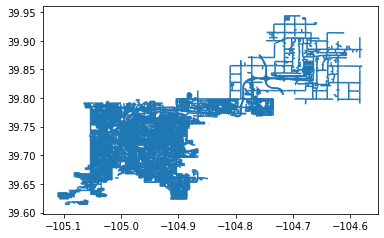

In [174]:
denver_streets_gdf.geometry.plot()

In [ ]:
#data source: https://data.drcog.org/dataset/edge-of-pavement-lines-2016


In [ ]:
image detection